In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import os

cwd=os.path.abspath('')
os.chdir('/mnt')
files=os.listdir(cwd)

import os
import pandas as pd
import scipy as sp
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('/mnt/Datasets/Brazil_CO2_df.csv')

df['yield_per_ha'] = df['Dry_Finished_Yield_Mass_kg']/df['Crop_Area_ha']
df['CO2_value'] = df['value']

###Subsetting
df_subset = df.loc[(df['result'] == 'emissions_per_area') & (df['Soil_Drainage'] == 'good') & \
                  (df['Fertilizer_Type'] == 'Compose your own NPK') & (df['Application_Method'] == 'Incorporate') & \
                  (df['Machine'] == 'herbicide spraying')]

df_subset = df_subset[['Soil_Organic_Matter', 'Soil_pH', 'Application_Rate_Unit_kg/ha', 'Crop_Protection_Application_Doses',\
                       'Num_Passes', 'Total_Water_Applied_mm', 'yield_per_ha', 'CO2_value']]

print(display(df_subset))
df_subset = df_subset[~df_subset.isna()]

####Yield per Area Train / Test Split
df_yield_per_ha_target = df_subset
X_full_data_yield_per_ha_target = df_yield_per_ha_target.drop(columns = ['yield_per_ha'])
y_full_data_yield_per_ha_target = df_yield_per_ha_target['yield_per_ha']

train_yield_per_ha_target, test_yield_per_ha_target = train_test_split(df_yield_per_ha_target, test_size = 0.2, random_state = 50)
X_train_yield_per_ha_target = train_yield_per_ha_target.drop(columns = ['yield_per_ha'])
X_test_yield_per_ha_target = test_yield_per_ha_target.drop(columns = ['yield_per_ha'])
y_train_yield_per_ha_target = train_yield_per_ha_target['yield_per_ha']
y_test_yield_per_ha_target = test_yield_per_ha_target['yield_per_ha']

kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

,Soil_Organic_Matter,Soil_pH,Application_Rate_Unit_kg/ha,Crop_Protection_Application_Doses,Num_Passes,Total_Water_Applied_mm,yield_per_ha,CO2_value
1,2.500000,5.5,300.0,14,15,350,3003.333333,-220.35
11,2.500000,5.5,200.0,14,15,350,3003.333333,-220.35
21,2.500000,5.5,150.0,14,15,350,3003.333333,-220.35
31,2.500000,5.5,300.0,18,15,350,2327.722222,3847.21
41,2.500000,5.5,300.0,18,15,350,2327.722222,3847.21
...,...,...,...,...,...,...,...,...
31431,2.500000,5.5,200.0,25,15,350,4710.000000,237.95
31671,4.160000,5.5,250.0,18,15,350,3116.176471,-648.15
31691,2.500000,5.5,250.0,21,15,350,3510.000000,912.52
31711,2.910000,5.5,250.0,22,15,350,1540.806452,529.23


None


In [40]:
print(np.mean(y_train_CO2_target))

215.10077709611446


In [35]:
###CO2 Value Target

#############################################################
########################### LASSO ###########################
#############################################################
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

lasso = make_pipeline(MinMaxScaler(), LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds))
lasso_model_CO2_value_target_train = lasso.fit(X_train_CO2_target, y_train_CO2_target)

print('Lasso')
print('Optimal alpha: ' + str(lasso_model_CO2_value_target_train[1].alpha_))
print('Coef: ' + str(lasso_model_CO2_value_target_train.named_steps['lassocv'].coef_))
print('Intercept: ' + str(lasso_model_CO2_value_target_train.named_steps['lassocv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, lasso_model_CO2_value_target_train.predict(X_test_CO2_target))))

lasso_model_CO2_value_target_full_data = lasso.fit(X_full_data_CO2_target, y_full_data_CO2_target)

# print(y_test_CO2_target)
# print(lasso_model_CO2_value_target_train.predict(X_test_CO2_target))

#############################################################
########################### RIDGE ###########################
#############################################################
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge = make_pipeline(MinMaxScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))
ridge_model_CO2_value_target_train = ridge.fit(X_train_CO2_target, y_train_CO2_target)

print('Ridge')
print('Optimal alpha: ' + str(ridge_model_CO2_value_target_train[1].alpha_))
print('Coef: ' + str(ridge_model_CO2_value_target_train.named_steps['ridgecv'].coef_))
print('Intercept: ' + str(ridge_model_CO2_value_target_train.named_steps['ridgecv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, ridge_model_CO2_value_target_train.predict(X_test_CO2_target))))

ridge_model_CO2_value_target_full_data = ridge.fit(X_full_data_CO2_target, y_full_data_CO2_target)

#############################################################
########################### ELASTICNET ######################
#############################################################
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elasticnet = make_pipeline(MinMaxScaler(), ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio))  
elastic_model_CO2_value_target_train = elasticnet.fit(X_train_CO2_target, y_train_CO2_target)

print('Elastic Net')
print('Optimal alpha: ' + str(elastic_model_CO2_value_target_train[1].alpha_))
print('Coef: ' + str(elastic_model_CO2_value_target_train.named_steps['elasticnetcv'].coef_))
print('Intercept: ' + str(elastic_model_CO2_value_target_train.named_steps['elasticnetcv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, elastic_model_CO2_value_target_train.predict(X_test_CO2_target))))

elastic_model_CO2_value_target_full_data = elasticnet.fit(X_full_data_CO2_target, y_full_data_CO2_target)

###CO2 Value Target

#############################################################
########################### svr ###########################
#############################################################
svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 0.0003))
svr_model_CO2_value_target_train = svr.fit(X_train_CO2_target, y_train_CO2_target)

print('SVR')
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, svr_model_CO2_value_target_train.predict(X_test_CO2_target))))

svr_model_CO2_value_target_full_data = svr.fit(X_full_data_CO2_target, y_full_data_CO2_target)

#############################################################
########################### lightgbm ###########################
#############################################################
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       ) 
lightgbm_model_CO2_value_target_train = lightgbm.fit(X_train_CO2_target, y_train_CO2_target)

print('lightgbm')
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, lightgbm_model_CO2_value_target_train.predict(X_test_CO2_target))))

lightgbm_model_CO2_value_target_full_data = lightgbm.fit(X_full_data_CO2_target, y_full_data_CO2_target)

#############################################################
########################### gbr ######################
#############################################################
gbr = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 10, loss = 'huber', random_state = 42)
gbr_model_CO2_value_target_train = gbr.fit(X_train_CO2_target, y_train_CO2_target)

print('gbr')
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, gbr_model_CO2_value_target_train.predict(X_test_CO2_target))))

gbr_model_CO2_value_target_full_data = gbr.fit(X_full_data_CO2_target, y_full_data_CO2_target)

#############################################################
########################### xgboost ######################
#############################################################
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgboost_model_CO2_value_target_train = xgboost.fit(X_train_CO2_target, y_train_CO2_target)

print('xgboost')
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, xgboost_model_CO2_value_target_train.predict(X_test_CO2_target))))

xgboost_model_CO2_value_target_full_data = xgboost.fit(X_full_data_CO2_target, y_full_data_CO2_target)

#############################################################
########################### ols ############################
#############################################################
ols = linear_model.LinearRegression()
ols_model_CO2_value_target_train = ols.fit(X_train_CO2_target, y_train_CO2_target)

print('ols')
print('Coef: ' + str(ols_model_CO2_value_target_train.coef_))
print('Intercept: ' + str(ols_model_CO2_value_target_train.intercept_))
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, ols_model_CO2_value_target_train.predict(X_test_CO2_target))))

ols_model_CO2_value_target_full_data = ols.fit(X_full_data_CO2_target, y_full_data_CO2_target)

Lasso
Optimal alpha: 5e-05
Coef: [-3662.19828211  -125.62195216   685.83509243  1241.07260721
     0.          -265.31486979   413.13630533]
Intercept: 1081.0502047564676
RMSE on test data: 582.7869335711935
Ridge
Optimal alpha: 14.5
Coef: [-1038.23766047    25.92693347   166.47122792   564.61411617
     0.          -251.70765579   192.9408893 ]
Intercept: 432.02158159658063
RMSE on test data: 679.2551193888984
Elastic Net
Optimal alpha: 0.0007
Coef: [-3618.67587742  -120.08103066   676.80553326  1233.46577269
     0.          -265.79207423   411.51789441]
Intercept: 1067.6879403302107
RMSE on test data: 583.1910751809943
SVR
RMSE on test data: 770.9209882780511
lightgbm
RMSE on test data: 486.38307118867107
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75,

In [37]:
ols = linear_model.LinearRegression()
ols_model_CO2_value_target_train = ols.fit(X_train_CO2_target, y_train_CO2_target)

print('ols')
print('Coef: ' + str(ols_model_CO2_value_target_train.coef_))
print('Intercept: ' + str(ols_model_CO2_value_target_train.intercept_))
print('RMSE on test data: ' + str(rmse(y_test_CO2_target, ols_model_CO2_value_target_train.predict(X_test_CO2_target))))

ols_model_CO2_value_target_full_data = ols.fit(X_full_data_CO2_target, y_full_data_CO2_target)

ols
Coef: [-6.36085360e+02 -7.53783982e+01  1.15655777e+00  4.77336829e+01
  1.98951966e-13 -2.65315243e+00  5.65680322e-02]
Intercept: 2077.0647846505103
RMSE on test data: 582.7870272396416


Text(0.5, 1.0, 'ols (Target: CO2 Value)')

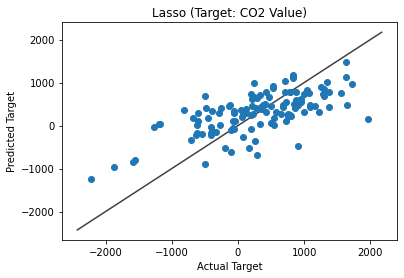

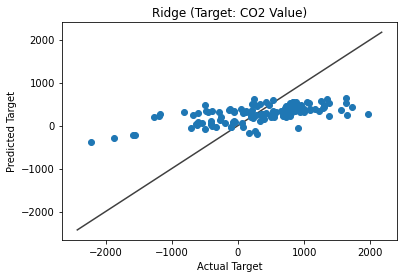

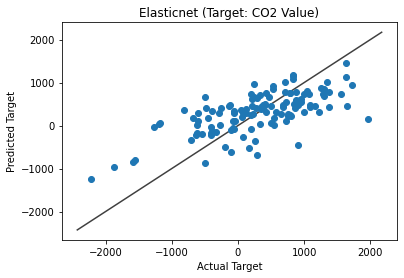

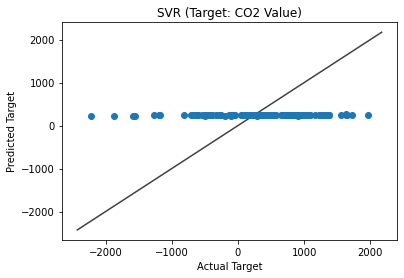

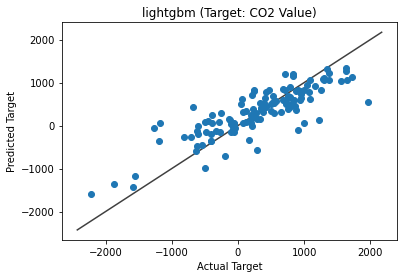

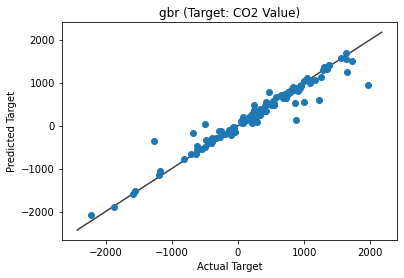

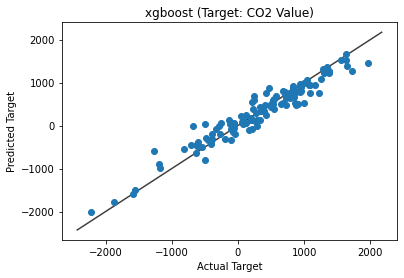

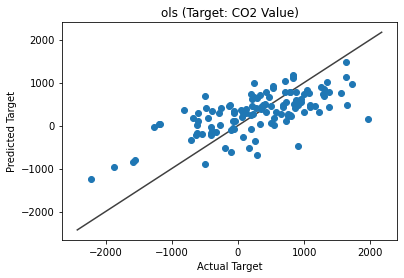

In [36]:
###Lasso
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, lasso_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Lasso (Target: CO2 Value)')

###Ridge
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, ridge_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Ridge (Target: CO2 Value)')

###Elasticnet
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, elastic_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Elasticnet (Target: CO2 Value)')

###svr
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, svr_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('SVR (Target: CO2 Value)')

###lightgbm
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, lightgbm_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('lightgbm (Target: CO2 Value)')

###gbr
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, gbr_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('gbr (Target: CO2 Value)')

###xgboost
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, xgboost_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('xgboost (Target: CO2 Value)')

###ols
fig, ax = plt.subplots()
ax.scatter(y_test_CO2_target, ols_model_CO2_value_target_train.predict(X_test_CO2_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('ols (Target: CO2 Value)')

In [9]:
optimal_alpha_lasso_CO2_value_target = lasso_model_CO2_value_target_train[1].alpha_
coef_lasso_CO2_value_target = lasso_model_CO2_value_target_train.named_steps['lassocv'].coef_
intercept_lasso_CO2_value_target = lasso_model_CO2_value_target_train.named_steps['lassocv'].intercept_

X_test_CO2_target_no_yield = X_test_CO2_target.loc[:,'Soil_Organic_Matter':'Total_Water_Applied_mm'].T
yield_per_ha_coef = coef_lasso_CO2_value_target[3]

coef_lasso_CO2_value_target_no_yield = np.array([coef_lasso_CO2_value_target[:3]])

yield_per_ha_preds = ((np.array([test_CO2_target['CO2_value']]) - np.matmul(coef_lasso_CO2_value_target_no_yield, X_test_CO2_target_no_yield) - intercept_lasso_CO2_value_target)/yield_per_ha_coef).T

yield_per_ha_test_values = np.array([y_test_yield_per_ha_target]).T

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

print(rmse(yield_per_ha_test_values, yield_per_ha_preds))
print(mae(yield_per_ha_test_values, yield_per_ha_preds))

0    3513.068986
dtype: float64
0    3324.016707
dtype: float64


In [58]:
yield_per_ha_mean = y_train_yield_per_ha_target.mean()
print(yield_per_ha_mean)
###Yield per Area Target

#############################################################
########################### LASSO ###########################
#############################################################
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
lasso = make_pipeline(MinMaxScaler(), LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds))
lasso_model_yield_per_ha_target_train = lasso.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('Lasso')
print('Optimal alpha: ' + str(lasso_model_yield_per_ha_target_train[1].alpha_))
print('Coef: ' + str(lasso_model_yield_per_ha_target_train.named_steps['lassocv'].coef_))
print('Intercept: ' + str(lasso_model_yield_per_ha_target_train.named_steps['lassocv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, lasso_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, lasso_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

lasso_model_yield_per_ha_full_data = lasso.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### RIDGE ###########################
#############################################################
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge = make_pipeline(MinMaxScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))
ridge_model_yield_per_ha_target_train = ridge.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('Ridge')
print('Optimal alpha: ' + str(ridge_model_yield_per_ha_target_train[1].alpha_))
print('Coef: ' + str(ridge_model_yield_per_ha_target_train.named_steps['ridgecv'].coef_))
print('Intercept: ' + str(ridge_model_yield_per_ha_target_train.named_steps['ridgecv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, ridge_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, ridge_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

ridge_model_yield_per_ha_target_full_data = ridge.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### ELASTICNET ######################
#############################################################
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elasticnet = make_pipeline(MinMaxScaler(), ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio))  
elastic_model_yield_per_ha_target_train = elasticnet.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('Elastic Net')
print('Optimal alpha: ' + str(elastic_model_yield_per_ha_target_train[1].alpha_))
print('Coef: ' + str(elastic_model_yield_per_ha_target_train.named_steps['elasticnetcv'].coef_))
print('Intercept: ' + str(elastic_model_yield_per_ha_target_train.named_steps['elasticnetcv'].intercept_))
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, elastic_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, elastic_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

elastic_model_yield_per_ha_target_full_data = elasticnet.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### svr ###########################
#############################################################
svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 0.0003))
svr_model_yield_per_ha_target_train = svr.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('SVR')
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, svr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, svr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

svr_model_yield_per_ha_target_full_data = svr.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### lightgbm ###########################
#############################################################
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves = 4,
                                       learning_rate = 0.01, 
                                       n_estimators = 5000,
                                       max_bin = 200, 
                                       bagging_fraction = 0.75,
                                       bagging_freq = 5, 
                                       bagging_seed = 7,
                                       feature_fraction = 0.2,
                                       feature_fraction_seed = 7,
                                       verbose = -1,
                                       ) 
lightgbm_model_yield_per_ha_target_train = lightgbm.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('lightgbm')
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, lightgbm_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, lightgbm_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

lightgbm_model_yield_per_ha_target_full_data = lightgbm.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### gbr ######################
#############################################################
gbr = GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 10, loss = 'huber', random_state = 42)
gbr_model_yield_per_ha_target_train = gbr.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('gbr')
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, gbr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, gbr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

gbr_model_yield_per_ha_target_full_data = gbr.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### xgboost ######################
#############################################################
xgboost = XGBRegressor(learning_rate = 0.005, n_estimators = 10000,
                                     max_depth = 3, min_child_weight = 0,
                                     gamma = 0, subsample = 0.7,
                                     colsample_bytree = 0.7,
                                     objective = 'reg:linear', nthread = -1,
                                     scale_pos_weight = 1, seed = 27,
                                     reg_alpha = 0.00006)
xgboost_model_yield_per_ha_target_train = xgboost.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('xgboost')
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, xgboost_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, xgboost_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

xgboost_model_yield_per_ha_target_full_data = xgboost.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

#############################################################
########################### stacking ######################
#############################################################
stack_gen = StackingCVRegressor(regressors = (ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor = xgboost,
                                use_features_in_secondary = True)
stack_gen_model_yield_per_ha_target_train = stack_gen.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

print('stack_gen')
print('RMSE on test data: ' + str(rmse(y_test_yield_per_ha_target, stack_gen_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))))
print('RMSE Scaled on test data: ' + str(rmse(y_test_yield_per_ha_target, stack_gen_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))/yield_per_ha_mean))

stack_gen_model_yield_per_ha_target_full_data = stack_gen.fit(X_full_data_yield_per_ha_target, y_full_data_yield_per_ha_target)

3591.560254962982
Lasso
Optimal alpha: 0.0008
Coef: [  399.95531147   144.9542041   -120.19724835 -1047.58915634
     0.           540.60955661  1520.14181231]
Intercept: 2916.779714089825
RMSE on test data: 1146.6305480309004
RMSE Scaled on test data: 0.31925694312003644
Ridge
Optimal alpha: 14.5
Coef: [ -88.7644328    -6.64785088   27.54681544 -387.69022809    0.
  407.68138933  308.52928561]
Intercept: 3430.909557665826
RMSE on test data: 1135.561203158725
RMSE Scaled on test data: 0.3161748996385497
Elastic Net
Optimal alpha: 0.0007
Coef: [  375.8208857    139.47655375  -114.1415069  -1035.5381638
     0.           538.77613926  1487.64334404]
Intercept: 2936.1843569509647
RMSE on test data: 1146.3158742853227
RMSE Scaled on test data: 0.31916932834449624
SVR
RMSE on test data: 1154.3540452898312
RMSE Scaled on test data: 0.32140740050085254
lightgbm
RMSE on test data: 1120.4259102115293
RMSE Scaled on test data: 0.3119607721082428
[LightGBM] [Warning] feature_fraction is set=0.2, 

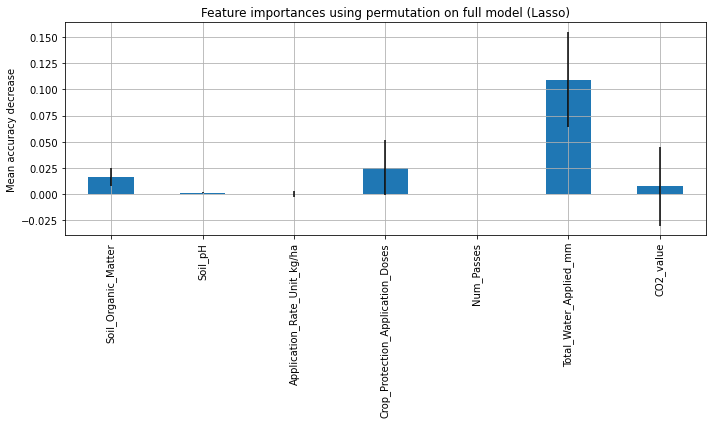

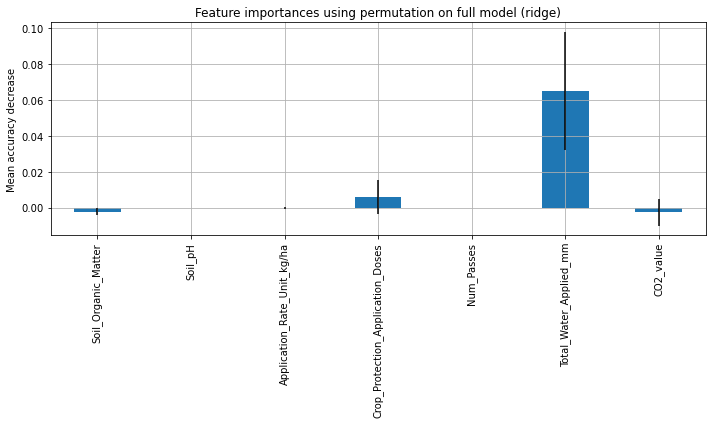

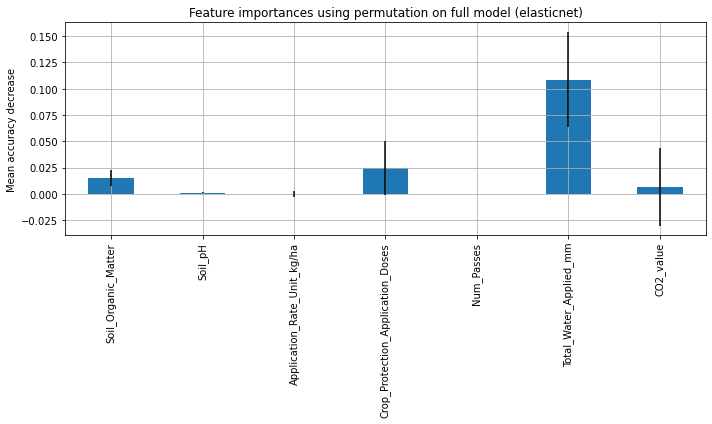

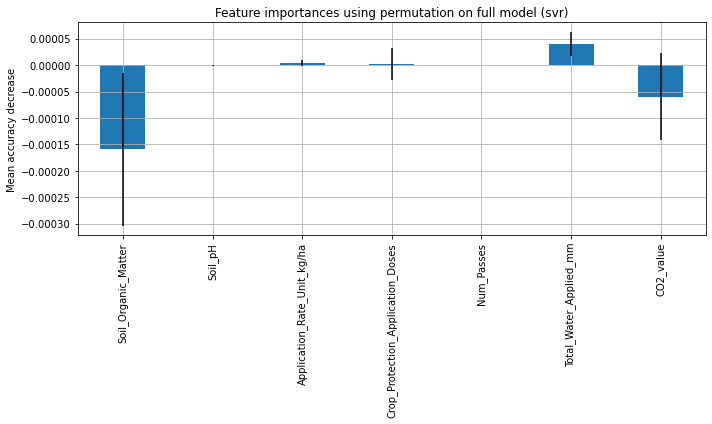

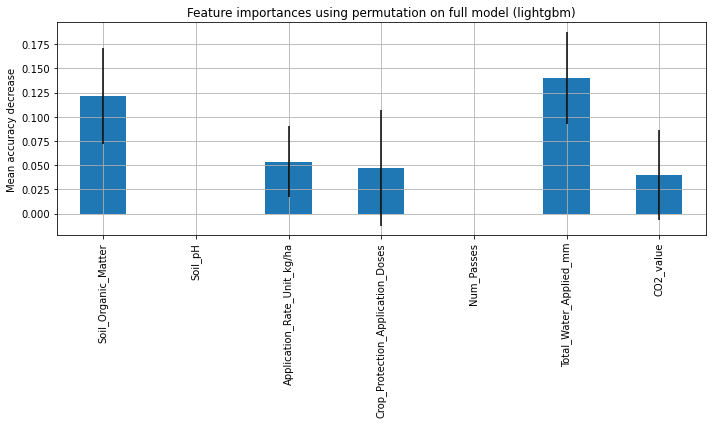

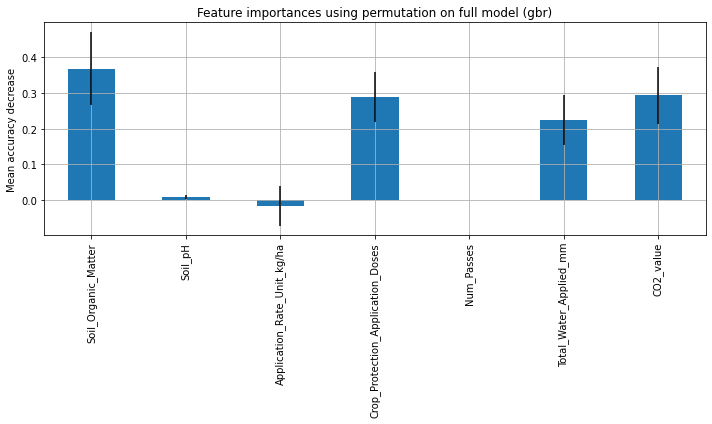

[20:07:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


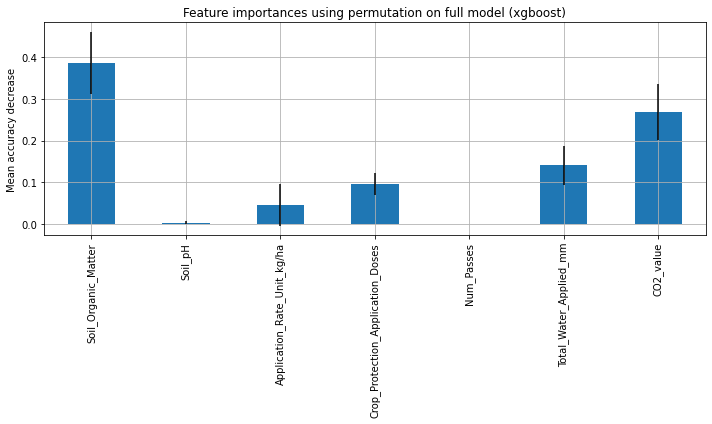

[20:08:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, cols

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted withou

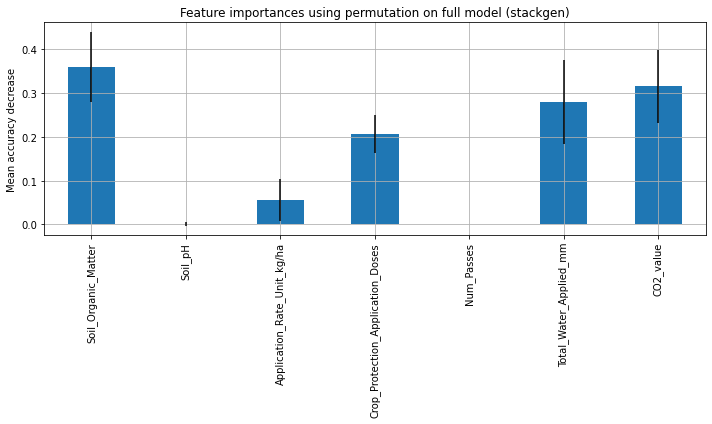

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted withou

In [59]:
from sklearn.inspection import permutation_importance

model_list = [lasso, ridge, elasticnet, svr, lightgbm, gbr, xgboost, stack_gen]
model_names = ['Lasso', 'ridge', 'elasticnet', 'svr', 'lightgbm', 'gbr', 'xgboost', 'stackgen']

for model in model_list:
    feature_names = X_train_yield_per_ha_target.columns
#     feature_names = [f"feature {i}" for i in range(X_train_yield_per_ha_target.shape[1])]
    model.fit(X_train_yield_per_ha_target, y_train_yield_per_ha_target)

    result = permutation_importance(
        model, X_test_yield_per_ha_target, y_test_yield_per_ha_target, n_repeats=10, random_state=42, n_jobs=2
    )

    model_importances = pd.Series(result.importances_mean, index = feature_names)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    model_importances.plot.bar(yerr = result.importances_std, ax = ax)
    ax.set_title("Feature importances using permutation on full model (" + str(model_names[model_list.index(model)]) + ')')
    ax.set_ylabel("Mean accuracy decrease")
    plt.grid()
    fig.tight_layout()
    plt.show()

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

Text(0.5, 1.0, 'xgboost (Target: yield per ha)')

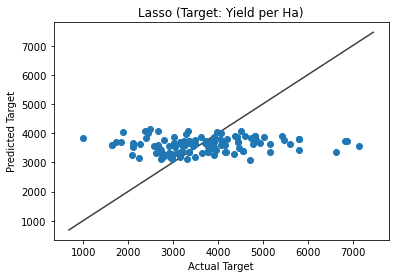

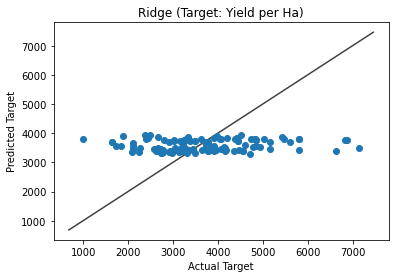

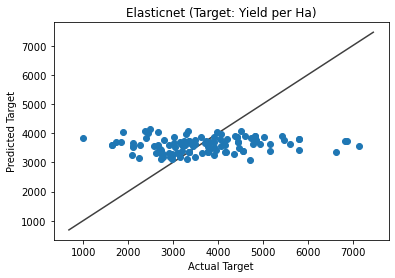

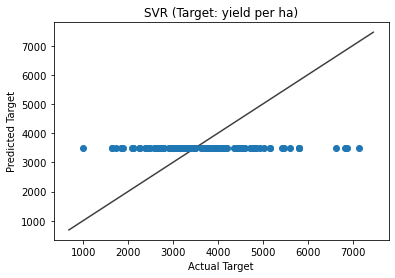

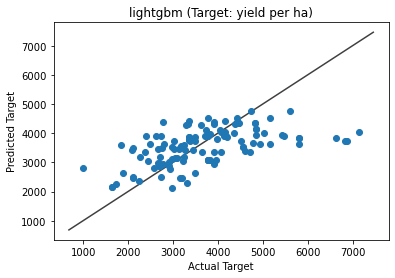

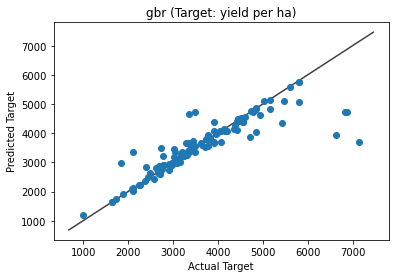

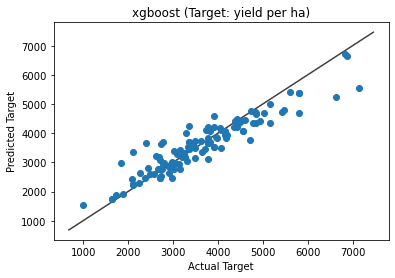

In [36]:
###Lasso
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, lasso_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Lasso (Target: Yield per Ha)')

###Ridge
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, ridge_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Ridge (Target: Yield per Ha)')

##Elasticnet
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, elastic_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Elasticnet (Target: Yield per Ha)')

###svr
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, svr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('SVR (Target: yield per ha)')

###lightgbm
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, lightgbm_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('lightgbm (Target: yield per ha)')

###gbr
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, gbr_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('gbr (Target: yield per ha)')

###xgboost
fig, ax = plt.subplots()
ax.scatter(y_test_yield_per_ha_target, xgboost_model_yield_per_ha_target_train.predict(X_test_yield_per_ha_target))
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('xgboost (Target: yield per ha)')

In [14]:
OLS_model_CO2_target = smf.ols(formula = 'CO2_value ~ Soil_Organic_Matter + yield_per_ha  + Crop_Protection_Application_Doses + Total_Water_Applied_mm ', data = df_subset)
res2 = OLS_model_CO2_target.fit()
print(res2.summary())

OLS_model_yield_per_ha_target = smf.ols(formula = 'yield_per_ha ~ Soil_Organic_Matter + CO2_value + Crop_Protection_Application_Doses + Total_Water_Applied_mm ', data = df_subset)
res2 = OLS_model_yield_per_ha_target.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:              CO2_value   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     108.5
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           1.06e-69
Time:                        17:28:33   Log-Likelihood:                -4744.5
No. Observations:                 612   AIC:                             9499.
Df Residuals:                     607   BIC:                             9521.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc